## Import require libraries

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import models, datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.auto import tqdm

In [ ]:
import os
from random import randint
import urllib
import zipfile

In [ ]:
!pip install -q torchmetrics
from torchmetrics.classification import MulticlassAccuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 21.6 MB/s eta 0:00:00


## Device Agnostic code

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Helper function

In [ ]:
# Functions to display single or a batch of sample images
def imshow(img):
    npimg = img[0].numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(img[1])
    plt.show()
    
def show_batch(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()    
    imshow(make_grid(images)) # Using Torchvision.utils make_grid function
    
def show_image(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    random_num = randint(0, len(images)-1)
    imshow(images[random_num])
    label = labels[random_num]
    print(f'Label: {label}, Shape: {images[random_num].shape}')

## Get dataset

In [ ]:
# Retrieve data directly from Stanford data source
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
  
# Unzip raw zip file
!unzip -qq 'tiny-imagenet-200.zip'

# Define main data directory
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

--2023-03-28 08:25:43--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  37.8MB/s    in 7.1s    

2023-03-28 08:25:50 (33.1 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



## preprocess validation data

In [ ]:
# Create separate validation subfolders for the validation images based on
# their labels indicated in the val_annotations txt file
val_img_dir = os.path.join(VALID_DIR, 'images')

# Open and read val annotations text file
fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

# Create dictionary to store img filename (word 0) and corresponding
# label (word 1) for every line in the txt file (as key value pair)
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

# Display first 10 entries of resulting val_img_dict dictionary
{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

{'val_0.JPEG': 'n03444034',
 'val_1.JPEG': 'n04067472',
 'val_2.JPEG': 'n04070727',
 'val_3.JPEG': 'n02808440',
 'val_4.JPEG': 'n02808440',
 'val_5.JPEG': 'n04399382',
 'val_6.JPEG': 'n04179913',
 'val_7.JPEG': 'n02823428',
 'val_8.JPEG': 'n04146614',
 'val_9.JPEG': 'n02226429'}

In [ ]:
# Create subfolders (if not present) for validation images based on label,
# and move images into the respective folders
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

## Image preprocess transform

In [ ]:
image_transform_pretrain = transforms.Compose([
                transforms.Resize(64), # Resize images to 64 x 64
                transforms.CenterCrop(56), # Center crop image
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),  # Images to tensors
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225])
])

## make datasets

In [ ]:
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform = image_transform_pretrain)
valid_dataset = datasets.ImageFolder(val_img_dir, transform = image_transform_pretrain)

In [ ]:
num_classes = len(train_dataset.classes)
num_classes

200

## Create Dataloader

In [ ]:
# Define batch size for DataLoaders
BATCH_SIZE = 32

# Create DataLoaders for pre-trained models (normalized based on specific requirements)
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                              shuffle = True, drop_last = True)

valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, 
                              drop_last = True)

In [ ]:
# for i, (x, y) in enumerate(train_dataloader):
#   print(x)
#   print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
#   print(y)
#   break

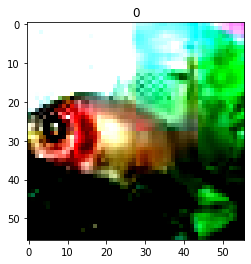

In [ ]:
## visulize image
imshow(train_dataset[0])

# Build models

## Xavier Initialization

In [ ]:
def weights_init(c_name):
    if isinstance(c_name, nn.Conv2d):
        torch.nn.init.xavier_uniform_(c_name.weight)
        torch.nn.init.zeros_(c_name.bias)
    elif isinstance(c_name, nn.Linear):
        torch.nn.init.xavier_uniform_(c_name.weight)
        torch.nn.init.zeros_(c_name.bias)

## Teacher Model

In [ ]:
class TeacherCNN(nn.Module):
  def __init__(self, in_channel: int, out_channel: int, hidden_channel:int,
               in_feature: int, out_feature: int):
    super().__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels = in_channel, out_channels = out_channel, kernel_size = 5, stride = 1, padding = 2),
        nn.Tanh(),
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels = out_channel, out_channels = hidden_channel, kernel_size = 5, stride = 1, padding = 2),
        nn.Tanh(),
    )
    self.conv_block3 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_channel, out_channels = hidden_channel, kernel_size = 5, stride = 1, padding = 2),
        nn.Tanh(),
    )
    self.conv_block4 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_channel, out_channels = hidden_channel, kernel_size = 5, stride = 1, padding = 2),
        nn.Tanh(),
    )
    self.conv_block5 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_channel, out_channels = hidden_channel, kernel_size = 5, stride = 1, padding = 2),
        nn.Tanh(),
    )
    self.conv_block6 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_channel, out_channels = hidden_channel, kernel_size = 5, stride = 1, padding = 2),
        nn.Tanh(),
    )
    self.conv_block7 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_channel, out_channels = hidden_channel, kernel_size = 5, stride = 1, padding = 2),
        nn.Tanh(),
    )
    self.conv_block8 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_channel, out_channels = hidden_channel, kernel_size = 5, stride = 1, padding = 2),
        nn.Tanh(),
    )
    self.conv_block9 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_channel, out_channels = hidden_channel, kernel_size = 5, stride = 1, padding = 2),
        nn.Tanh(),
    )
    self.conv_block10 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_channel, out_channels = hidden_channel, kernel_size = 5, stride = 1, padding = 2),
        nn.Tanh(),
    )
    self.conv_block11 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_channel, out_channels = hidden_channel, kernel_size = 5, stride = 1, padding = 2),
        nn.Tanh(),
    )
    self.conv_block12 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_channel, out_channels = hidden_channel, kernel_size = 5, stride = 1, padding = 2),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size = 5, stride = 3)
    )
    self.fc1_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_channel*18*18, out_features = in_feature),
        nn.Tanh(),
        nn.Linear(in_features = in_feature, out_features = out_feature)
    )


  def forward(self, x):
    conv_x_half =  self.conv_block6(self.conv_block5(self.conv_block4(self.conv_block3(self.conv_block2(self.conv_block1(x))))))
    conv_x =  self.conv_block12(self.conv_block11(self.conv_block10(self.conv_block9(self.conv_block8(self.conv_block7(conv_x_half))))))
    # print(f"conv_x shape: {conv_x.shape}")
    return self.fc1_layer(conv_x)

teacher = TeacherCNN(in_channel = 3, out_channel = 12, hidden_channel = 10, in_feature = 512, out_feature = num_classes).to(device)
teacher

TeacherCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
  )
  (conv_block2): Sequential(
    (0): Conv2d(12, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
  )
  (conv_block3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
  )
  (conv_block4): Sequential(
    (0): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
  )
  (conv_block5): Sequential(
    (0): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
  )
  (conv_block6): Sequential(
    (0): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
  )
  (conv_block7): Sequential(
    (0): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
  )
  (conv_block8): Sequential(
    (0): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
 

## Student Model

In [ ]:
class StudentCNN(nn.Module):
  def __init__(self, in_channel: int, out_channel: int, hidden_channel:int,
               in_feature: int, out_feature: int):
    super().__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels = in_channel, out_channels = out_channel, kernel_size = 5, stride = 1, padding = 2),
        nn.ReLU(),
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels = out_channel, out_channels = hidden_channel, kernel_size = 5, stride = 1, padding = 2),
        nn.ReLU(),
    )
    self.conv_block3 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_channel, out_channels = hidden_channel, kernel_size = 5, stride = 1, padding = 2),
        nn.ReLU(),
    )
    self.conv_block4 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_channel, out_channels = hidden_channel, kernel_size = 5, stride = 1, padding = 2),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size = 5, stride = 3)
    )

    self.fc1_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_channel*18*18, out_features = in_feature),
        nn.ReLU(),
        nn.Linear(in_features = in_feature, out_features = out_feature)
    )


  def forward(self, x):
    conv_x =  self.conv_block4(self.conv_block3(self.conv_block2(self.conv_block1(x))))
    # print(f"conv_x shape: {conv_x.shape}")
    return self.fc1_layer(conv_x)

student = StudentCNN(in_channel = 3, out_channel = 12, hidden_channel = 10, in_feature = 512, out_feature = num_classes).to(device)
student

StudentCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (conv_block2): Sequential(
    (0): Conv2d(12, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (conv_block3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (conv_block4): Sequential(
    (0): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=5, stride=3, padding=0)
  )
  (fc1_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3240, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=200, bias=True)
  )
)

## Loss and Accuray Functions

In [ ]:
# Loss
loss_fn = nn.CrossEntropyLoss()

# Accuracy
accuracy_fn = MulticlassAccuracy(num_classes = num_classes).to(device)

## Train and Test Loop

In [ ]:
# train
def train_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, 
               accuracy_fn, device: torch.device = device):
  
  train_loss, train_acc = 0, 0

  for batch, (x_train, y_train) in enumerate(dataloader):

    if device == 'cuda':
      x_train, y_train = x_train.to(device), y_train.to(device)

    model.train()
    # 1. Forward
    y_pred = model(x_train)

    # 2. Loss
    loss = loss_fn(y_pred, y_train)
    acc = accuracy_fn(y_train, torch.argmax(y_pred, dim = 1))
    # print("train")
    # print(f"acutal: {y_train}")
    # print(f"pred: {torch.argmax(y_pred, dim = 1)}")
    train_loss += loss
    train_acc += acc

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. Backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc


def test_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, accuracy_fn, device: torch.device = device):
  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for x_test, y_test in dataloader:
      if device == 'cuda':
        x_test, y_test = x_test.to(device), y_test.to(device)

      # 1. Forward
      test_pred = model(x_test)

      # 2. Loss
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, torch.argmax(test_pred, dim = 1))
      # print("test")
      # print(f"acutal: {y_test}")
      # print(f"pred: {torch.argmax(test_pred, dim = 1)}")

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

## Loss and Accuracy plot vs Epoch

In [ ]:
def plotplot(train_losses, test_losses, train_acces, test_acces):
  plt.figure(figsize = (25,8))
  # plt.plot(range(1, epoches*(len(train_dataloader)*BATCH_SIZE) + 1), train)
  plt.subplot(1,2,1)
  plt.plot(range(len(train_losses)),train_losses, label = "Train Loss")
  plt.plot(range(len(test_losses)),test_losses, label = "Test Loss")
  plt.xlabel("Epoches")
  plt.ylabel("Loss")
  plt.title("Loss vs Epoches")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(range(len(train_acces)),train_acces, label = "Train Accuracy")
  plt.plot(range(len(test_acces)),test_acces, label = "Test Accuracy")
  plt.xlabel("Epoches")
  plt.ylabel("Accuracy")
  plt.title("Accuracy vs Epoches")
  plt.legend()

  plt.show()

## only train teacher

In [ ]:
torch.manual_seed(64)
torch.cuda.manual_seed(64)
teacher = TeacherCNN(in_channel = 3, out_channel = 12, hidden_channel = 10, in_feature = 512, out_feature = num_classes).to(device)

# initialize Xavier weights
teacher.apply(weights_init)

# optimizer function
optimizer = torch.optim.Adam(params = teacher.parameters(), lr = 1e-3)

train_losses, test_losses = [], []
train_acces, test_acces = [], []

# train model
epoches = 10

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):
  train_loss, train_acc = train_loop(model = teacher, dataloader = train_dataloader,
                                     loss_fn = loss_fn, optimizer = optimizer, 
                                     accuracy_fn = accuracy_fn, device = device)
  test_loss, test_acc = test_loop(model = teacher, dataloader = valid_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  print(f"Epoch: {epoch + 1}  Train Loss: {train_loss:.4f} / Test Loss: {test_loss:.4f} -/- Train Accuracy: {train_acc:.4f} / Test Accuracy: {test_acc:.4f}")

  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  train_acces.append(train_acc.item())
  test_acces.append(test_acc.item())

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 4.8713 / Test Loss: 4.5830 -/- Train Accuracy: 0.0055 / Test Accuracy: 0.0033
Epoch: 2  Train Loss: 4.4891 / Test Loss: 4.4101 -/- Train Accuracy: 0.0110 / Test Accuracy: 0.0040
Epoch: 3  Train Loss: 4.3575 / Test Loss: 4.3668 -/- Train Accuracy: 0.0133 / Test Accuracy: 0.0042
Epoch: 4  Train Loss: 4.2660 / Test Loss: 4.2973 -/- Train Accuracy: 0.0152 / Test Accuracy: 0.0043
Epoch: 5  Train Loss: 4.1991 / Test Loss: 4.2569 -/- Train Accuracy: 0.0164 / Test Accuracy: 0.0046
Epoch: 6  Train Loss: 4.1504 / Test Loss: 4.1993 -/- Train Accuracy: 0.0174 / Test Accuracy: 0.0049
Epoch: 7  Train Loss: 4.1104 / Test Loss: 4.2010 -/- Train Accuracy: 0.0184 / Test Accuracy: 0.0048
Epoch: 8  Train Loss: 4.0594 / Test Loss: 4.1645 -/- Train Accuracy: 0.0194 / Test Accuracy: 0.0051
Epoch: 9  Train Loss: 4.0190 / Test Loss: 4.1520 -/- Train Accuracy: 0.0200 / Test Accuracy: 0.0051
Epoch: 10  Train Loss: 3.9902 / Test Loss: 4.1703 -/- Train Accuracy: 0.0208 / Test Accuracy: 0.0049

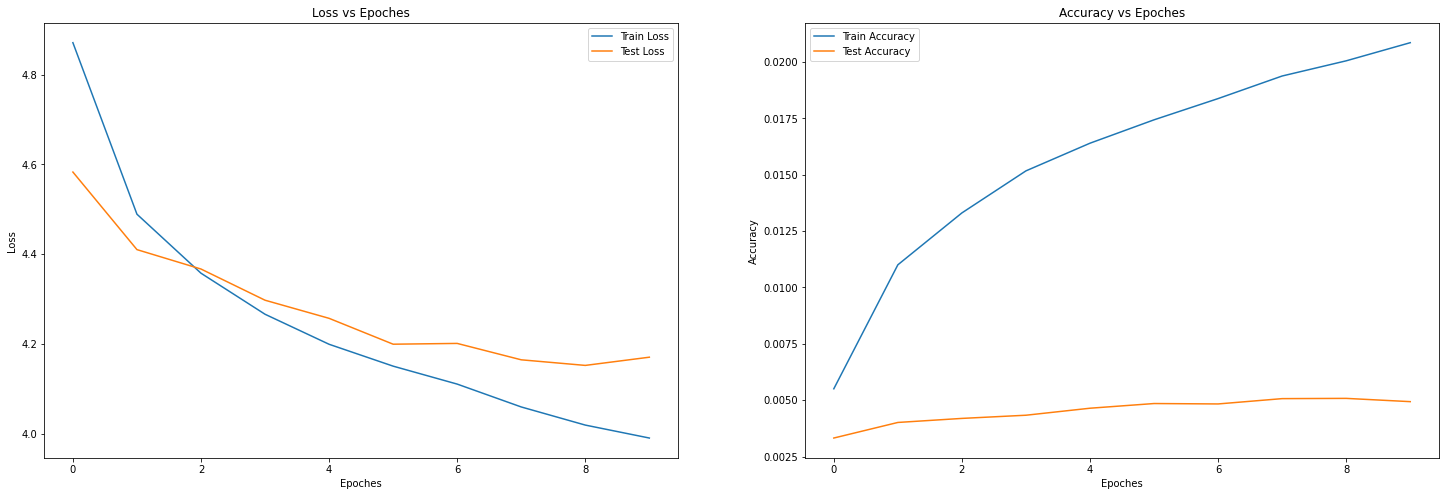

In [ ]:
plotplot(train_losses, test_losses, train_acces, test_acces)

## Train student network

In [ ]:
torch.manual_seed(64)
torch.cuda.manual_seed(64)
student = StudentCNN(in_channel = 3, out_channel = 12, hidden_channel = 10, in_feature = 512, out_feature = num_classes).to(device)

# initialize Xavier weights
student.apply(weights_init)

# optimizer function
optimizer = torch.optim.Adam(params = teacher.parameters(), lr = 1e-4)


train_losses, test_losses = [], []
train_acces, test_acces = [], []

# train model
epoches = 10

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):
  train_loss, train_acc = train_loop(model = student, dataloader = train_dataloader,
                                     loss_fn = loss_fn, optimizer = optimizer, 
                                     accuracy_fn = accuracy_fn, device = device)
  test_loss, test_acc = test_loop(model = student, dataloader = valid_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  print(f"Epoch: {epoch + 1}  Train Loss: {train_loss:.4f} / Test Loss: {test_loss:.4f} -/- Train Accuracy: {train_acc:.4f} / Test Accuracy: {test_acc:.4f}")

  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  train_acces.append(train_acc.item())
  test_acces.append(test_acc.item())

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 5.2997 / Test Loss: 5.2996 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 2  Train Loss: 5.2998 / Test Loss: 5.2995 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 3  Train Loss: 5.2998 / Test Loss: 5.2994 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 4  Train Loss: 5.2998 / Test Loss: 5.2994 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 5  Train Loss: 5.2998 / Test Loss: 5.2996 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0002
Epoch: 6  Train Loss: 5.2998 / Test Loss: 5.2999 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 7  Train Loss: 5.2999 / Test Loss: 5.2994 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 8  Train Loss: 5.2997 / Test Loss: 5.2994 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 9  Train Loss: 5.2998 / Test Loss: 5.2996 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 10  Train Loss: 5.2997 / Test Loss: 5.2994 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003

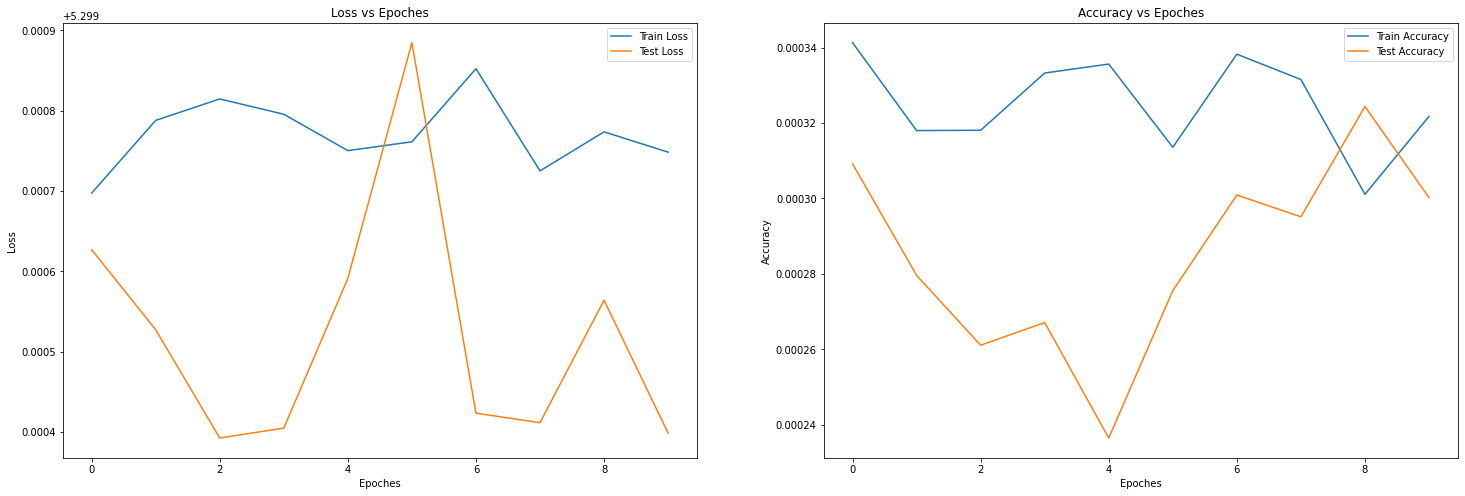

In [ ]:
plotplot(train_losses, test_losses, train_acces, test_acces)

## EMA

In [ ]:
class EMA():
  def cal_loss_with(student_loss, teacher_loss, alpha):
    loss = alpha * student_loss + (1-alpha) * teacher_loss
    return loss

  def cal_loss_without(student_pred, teacher_pred, loss_fn):
    loss = loss_fn(student_pred, teacher_pred)
    return loss

ema = EMA()

## train loop for TS with EMA

In [ ]:
# train
def st_train_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, 
               accuracy_fn, device: torch.device = device):
  
  train_loss, train_acc = 0, 0

  alpha = 0.2
  for batch, (x_train, y_train) in enumerate(dataloader):

    if device == 'cuda':
      x_train, y_train = x_train.to(device), y_train.to(device)

    model.train()
    # 1. Forward
    y_train_teacher = teacher(x_train)
    y_pred = model(x_train)

    # 2. Loss
    st_loss = loss_fn(y_pred, y_train)
    ta_loss = loss_fn(y_train_teacher, y_pred)
    loss = ema.cal_loss_with(st_loss, ta_loss, alpha)
    acc = accuracy_fn(y_train, torch.argmax(y_pred, dim = 1))
    train_loss += loss
    train_acc += acc

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. Backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc


def st_test_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, accuracy_fn, device: torch.device = device):
  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for x_test, y_test in dataloader:
      if device == 'cuda':
        x_test, y_test = x_test.to(device), y_test.to(device)

      # 1. Forward
      test_pred = model(x_test)

      # 2. Loss
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, torch.argmax(test_pred, dim = 1))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

 ## Train student from teacher

In [ ]:
torch.manual_seed(64)
torch.cuda.manual_seed(64)
student = StudentCNN(in_channel = 3, out_channel = 12, hidden_channel = 10, in_feature = 512, out_feature = num_classes).to(device)

# initialize Xavier weights
student.apply(weights_init)

# optimizer function
optimizer = torch.optim.Adam(params = teacher.parameters(), lr = 1e-4)


train_losses, test_losses = [], []
train_acces, test_acces = [], []

# train model
epoches = 10

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):
  train_loss, train_acc = st_train_loop(model = student, dataloader = train_dataloader,
                                     loss_fn = loss_fn, optimizer = optimizer, 
                                     accuracy_fn = accuracy_fn, device = device)
  test_loss, test_acc = st_test_loop(model = student, dataloader = valid_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  print(f"Epoch: {epoch + 1}  Train Loss: {train_loss:.4f} / Test Loss: {test_loss:.4f} -/- Train Accuracy: {train_acc:.4f} / Test Accuracy: {test_acc:.4f}")

  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  train_acces.append(train_acc.item())
  test_acces.append(test_acc.item())

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  Train Loss: -7714.5342 / Test Loss: 5.2996 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 2  Train Loss: -8444.3789 / Test Loss: 5.2995 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 3  Train Loss: -9174.6748 / Test Loss: 5.2994 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 4  Train Loss: -9904.1396 / Test Loss: 5.2994 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 5  Train Loss: -10634.1113 / Test Loss: 5.2996 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0002
Epoch: 6  Train Loss: -11363.6172 / Test Loss: 5.2999 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 7  Train Loss: -12091.8252 / Test Loss: 5.2994 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 8  Train Loss: -12824.4014 / Test Loss: 5.2994 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 9  Train Loss: -13551.9561 / Test Loss: 5.2996 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 10  Train Loss: -14284.1543 / Test Loss: 5.2994 -/- 

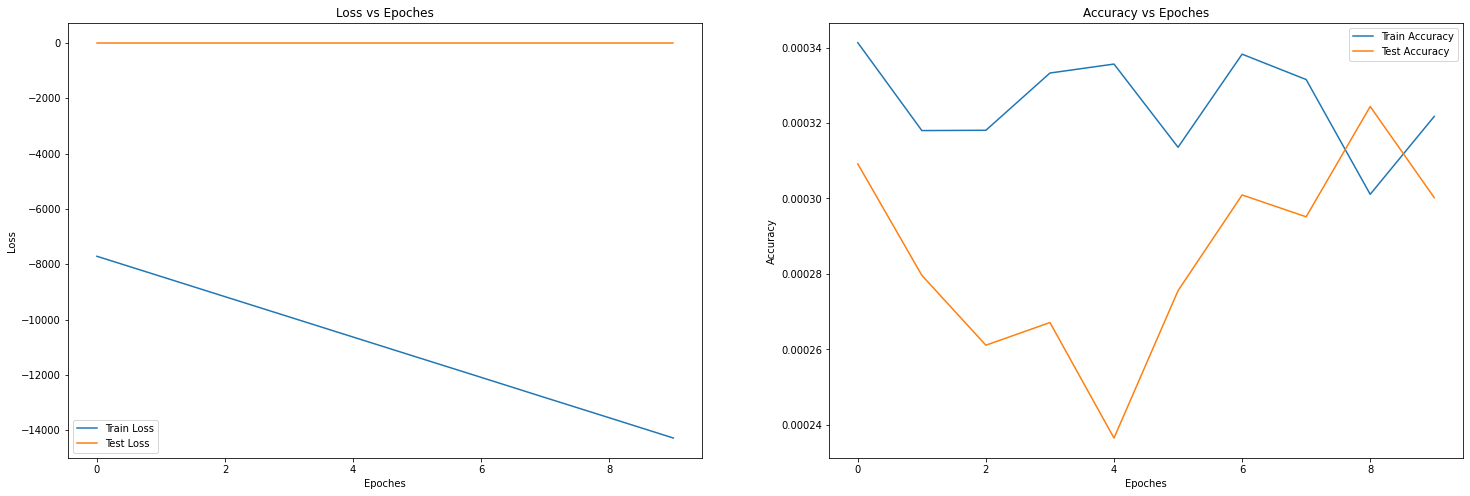

In [ ]:
plotplot(train_losses, test_losses, train_acces, test_acces)

## train loop for TS without EMA

In [ ]:
# train
def NOEMA_train_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, 
               accuracy_fn, device: torch.device = device):
  
  train_loss, train_acc = 0, 0

  alpha = 0.2
  for batch, (x_train, y_train) in enumerate(dataloader):

    if device == 'cuda':
      x_train, y_train = x_train.to(device), y_train.to(device)

    model.train()
    # 1. Forward
    y_train_teacher = teacher(x_train)
    y_pred = model(x_train)

    # 2. Loss
    loss = cal_loss_without(y_pred, y_train_teacher, loss_fn)
    # ta_loss = loss_fn(y_train_teacher, y_pred)

    acc = accuracy_fn(y_train, torch.argmax(y_pred, dim = 1))
    train_loss += loss
    train_acc += acc

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. Backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc


def NOEMA_test_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, accuracy_fn, device: torch.device = device):
  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for x_test, y_test in dataloader:
      if device == 'cuda':
        x_test, y_test = x_test.to(device), y_test.to(device)

      # 1. Forward
      test_pred = model(x_test)

      # 2. Loss
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, torch.argmax(test_pred, dim = 1))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

 ## Train student from teacher

In [ ]:
torch.manual_seed(64)
torch.cuda.manual_seed(64)
student = StudentCNN(in_channel = 3, out_channel = 12, hidden_channel = 10, in_feature = 512, out_feature = num_classes).to(device)

# initialize Xavier weights
student.apply(weights_init)

# optimizer function
optimizer = torch.optim.Adam(params = teacher.parameters(), lr = 1e-4)


train_losses, test_losses = [], []
train_acces, test_acces = [], []

# train model
epoches = 10

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):
  train_loss, train_acc = NOEMA_train_loop(model = student, dataloader = train_dataloader,
                                     loss_fn = loss_fn, optimizer = optimizer, 
                                     accuracy_fn = accuracy_fn, device = device)
  test_loss, test_acc = NOEMA_test_loop(model = student, dataloader = valid_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  print(f"Epoch: {epoch + 1}  Train Loss: {train_loss:.4f} / Test Loss: {test_loss:.4f} -/- Train Accuracy: {train_acc:.4f} / Test Accuracy: {test_acc:.4f}")

  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  train_acces.append(train_acc.item())
  test_acces.append(test_acc.item())

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  Train Loss: -6641.7715 / Test Loss: 5.2996 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 2  Train Loss: -176750.9219 / Test Loss: 5.2995 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 3  Train Loss: -346859.1875 / Test Loss: 5.2994 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 4  Train Loss: -516963.8438 / Test Loss: 5.2994 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 5  Train Loss: -687073.2500 / Test Loss: 5.2996 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0002
Epoch: 6  Train Loss: -857177.6250 / Test Loss: 5.2999 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 7  Train Loss: -1027256.8125 / Test Loss: 5.2994 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 8  Train Loss: -1197280.2500 / Test Loss: 5.2994 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 9  Train Loss: -1367235.7500 / Test Loss: 5.2996 -/- Train Accuracy: 0.0003 / Test Accuracy: 0.0003
Epoch: 10  Train Loss: -1537199.3750 / Test L

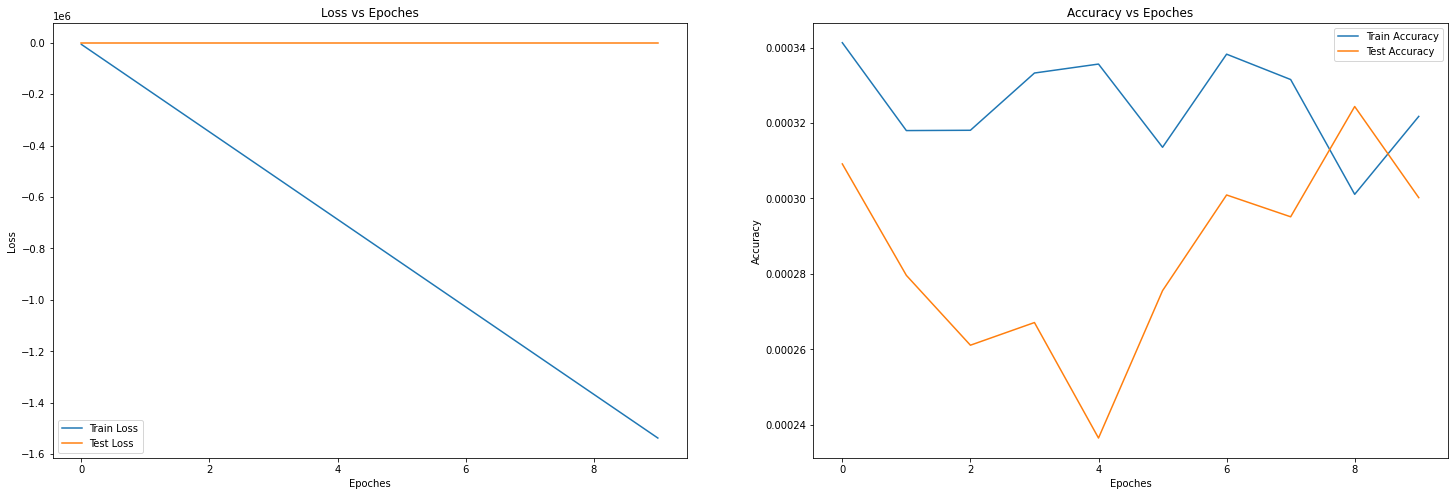

In [ ]:
plotplot(train_losses, test_losses, train_acces, test_acces)